In [1]:
# %matplotlib notebook
import numpy as np
import os
from matplotlib import image, pyplot as plt
import json
from celluloid import Camera
from collections import defaultdict

_ZI = np.complex(0, 1)

In [2]:
from pywave.scattering.elastic_string import ElasticString # Properties of a segment of string
from pywave.scattering.helmholtz_1d_boundary import Helmholtz1DBoundary # Scattering by a change in string properties
from pywave.scattering.medium_boundary import MediumBoundary
from pywave.scattering.multiple_scatterer import MultipleScatterer # Multiple scattering module

## Scattering by two boundaries in series
\begin{align}
&\textbf{s}^+ = \textbf{R}_0^+\textbf{i}^+
+ \textbf{T}_0^-\textbf{D}\textbf{b}_{0}\\
&\textbf{a} = \textbf{T}_0^+\textbf{i}^+
+ \textbf{R}_0^-\textbf{D}\textbf{b}\\
&\textbf{b} = \textbf{T}_{1}^-\textbf{i}^-
+ \textbf{R}_{1}^+\textbf{D}\textbf{a}\\
&\textbf{s}^- = \textbf{R}_{1}^-\textbf{i}^-
+ \textbf{T}_{1}^+\textbf{D}\textbf{a}
\end{align}
Combining these gives
\begin{align}
&
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}
=
\begin{pmatrix}
\textbf{T}_0^+ & \textbf{0} \\ \textbf{0} & \textbf{T}_1^-
\end{pmatrix}
\begin{pmatrix}
\textbf{i}^+ \\ \textbf{i}^-
\end{pmatrix}
+
\begin{pmatrix}
\textbf{0} & \textbf{R}_0^-\textbf{D} \\ \textbf{T}_{1}^+\textbf{D} & \textbf{0}
\end{pmatrix}
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}.
\end{align}

## Multiple scattering
\begin{align}
&\textbf{s}^+ = \textbf{R}_0^+\textbf{i}^+
+ \textbf{T}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_0 = \textbf{T}_0^+\textbf{i}^+
+ \textbf{R}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_n = \textbf{T}_n^+\textbf{D}_{n-1}\textbf{a}_{n-1}
+ \textbf{R}_n^-\textbf{D}_{n}\textbf{b}_{n}\\
&\textbf{b}_n = \textbf{T}_{n+1}^-\textbf{D}_{n+1}\textbf{b}_{n+1}
+ \textbf{R}_{n+1}^+\textbf{D}_{n}\textbf{a}_{n}\\
&\textbf{b}_{N-1} = \textbf{T}_{N}^-\textbf{i}^-
+ \textbf{R}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}\\
&\textbf{s}^- = \textbf{R}_{N}^-\textbf{i}^-
+ \textbf{T}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}
\end{align}
Combining these gives
\begin{align}
&
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix}
=
\begin{pmatrix}
\textbf{B}^+ & \textbf{0} \\ \textbf{0} & \textbf{B}^-
\end{pmatrix}
\begin{pmatrix}
\textbf{i}^+ \\ \textbf{i}^-
\end{pmatrix}
+
\begin{pmatrix}
\textbf{A}_{00} & \textbf{A}_{11} \\ \textbf{A}_{10} & \textbf{A}_{11}
\end{pmatrix}
\begin{pmatrix}
\textbf{a} \\ \textbf{b}
\end{pmatrix},
\end{align}
where
\begin{align}
&\textbf{B}^+ = \begin{pmatrix}
\textbf{T}_0^+\\ \textbf{0} \\ \cdots \\  \textbf{0}
\end{pmatrix},
\quad
\textbf{B}^- = \begin{pmatrix}
\textbf{0} \\ \cdots \\  \textbf{0} \\ \textbf{T}_N^-
\end{pmatrix},
\\
&\textbf{A}_{00} = \begin{pmatrix}
\textbf{0}                     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{T}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{T}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{T}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\end{pmatrix},
\quad
\textbf{A}_{01} = \begin{pmatrix}
\textbf{R}_0^-\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-2}^-\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N-1}^-\textbf{D}_{N-1}
\end{pmatrix},\\
&\textbf{A}_{10} = \begin{pmatrix}
\textbf{R}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N}^+\textbf{D}_{N-1}
\end{pmatrix},
\quad
\textbf{A}_{11} = \begin{pmatrix}
\textbf{0} & \textbf{T}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{0} & \textbf{T}_2^-\textbf{D}_2 & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \textbf{0}  &  \textbf{0}  & \cdots  & \textbf{T}_{N-1}^-\textbf{D}_{N-1} \\
\textbf{0} & \textbf{0} & \textbf{0} & \cdots & \textbf{0}
\end{pmatrix}.
\end{align}

We can eliminate $\textbf{b}$ with
\begin{align}
\textbf{b} &= \big(\textbf{I} - \textbf{A}_{11}\big)^{-1}\big(\textbf{B}^-\textbf{i}^- + \textbf{A}_{10}\textbf{a}\big)
= \textbf{C}^-\textbf{i}^- + \textbf{C}_{10}\textbf{a},\\
\textbf{a} &= \big(\textbf{I} - \textbf{A}_{00} - \textbf{A}_{01}\textbf{C}_{10}\big)^{-1}\big(
\textbf{B}^+\textbf{i}^+ + \textbf{A}_{01}\textbf{C}^-\textbf{i}^-\big)
\end{align}

In [3]:
period = 4
lhs = ElasticString(m=2, period=period)
mid = ElasticString(kappa=13, period=period)
rhs = ElasticString(kappa=6, period=period)
s0 = Helmholtz1DBoundary(lhs, mid, position=0)
s1 = Helmholtz1DBoundary(mid, rhs, position=4)

In [4]:
for bdy in [s0, s1]:
    print(vars(bdy))
    bdy.solve()
    bdy.test_boundary_conditions()
    bdy.test_energy()
    bdy.test_power_input()

{'position': 0, 'media': [<pywave.scattering.elastic_string.ElasticString object at 0x7f4359f7beb8>, <pywave.scattering.elastic_string.ElasticString object at 0x7f4359f7be48>], 'condition_types': [{'displacement': True}, {'displacement': True}]}
u(0) = 1.439607805437114 = 1.439607805437114
\sigma(0) = 2.4897569199005702j = 2.4897569199005702j
Boundary conditions are OK
Energy is OK
Test power input, from_left=True:
	-3.438525233229448, -3.4385252332294476
	OK
Test power input, from_left=False:
	4.383276815554534, 4.3832768155545345
	OK
{'position': 4, 'media': [<pywave.scattering.elastic_string.ElasticString object at 0x7f4359f7bef0>, <pywave.scattering.elastic_string.ElasticString object at 0x7f4359f7bf60>], 'condition_types': [{'displacement': True}, {'displacement': True}]}
u(0) = 1.5954627333817362 = 1.5954627333817362
\sigma(0) = 2.2911318826993954j = 2.291131882699395j
Boundary conditions are OK
Energy is OK
Test power input, from_left=True:
	-4.2860235029662075, -4.2860235029662

In [5]:
ms = MultipleScatterer([s0, s1])
print(ms.xlim)
for med in ms.media:
    print(med.xlim)

(0.0, 4.0)
[-inf   0.]
[0. 4.]
[ 4. inf]


In [6]:
vars(ms)

{'scatterers': [<pywave.scattering.helmholtz_1d_boundary.Helmholtz1DBoundary at 0x7f4359f7be10>,
 'media': [<pywave.scattering.elastic_string.ElasticString at 0x7f4359f7beb8>,
 'num_media': 3,
 'num_interior_media': 1,
 'slices': [slice(0, 1, None)],
 'num_unknowns': 1}

In [7]:
ms.solve()

In [8]:
ms.test_energy()
# ms.test_swap()

Energy is OK


In [9]:
ms.test_power_input()

Test power input, from_left=True:
	-3.1736796626444272, -3.1736796626444264
	OK
Test power input, from_left=False:
	2.748487211324101, 2.748487211324101
	OK


In [10]:
ms.test_boundary_conditions()


Test boundary conditions at boundary 0:
displacement = (0.6328263124898319+0.3770522407813619j) = (0.6328263124898319+0.3770522407813619j)?
stress = (1.6751989673618928+6.0741926497379835j) = (1.675198967361893+6.0741926497379835j)?

Test boundary conditions at boundary 1:
displacement = (0.18321340505767772+0.992225865420135j) = (0.1832134050576778+0.992225865420135j)?
stress = (-3.817737345530408-3.1427085258652876j) = (-3.8177373455304084-3.142708525865288j)?
Boundary conditions are OK


<AxesSubplot:title={'center':'u at t=0s'}, xlabel='x, m', ylabel='u, m'>

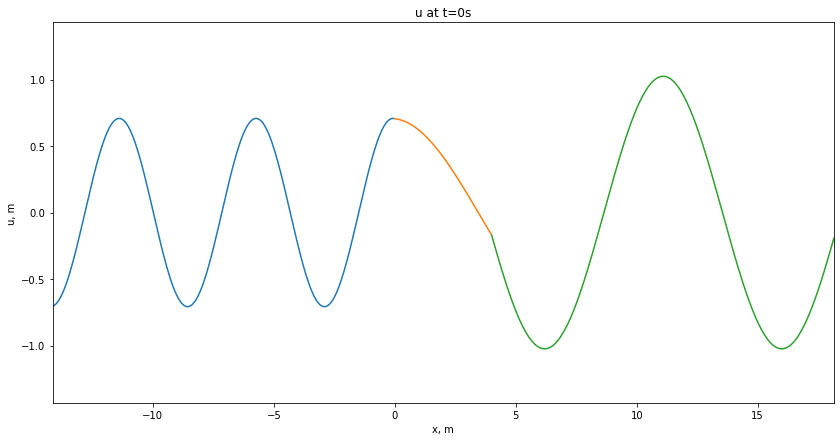

In [11]:
ms.plot_expansion()

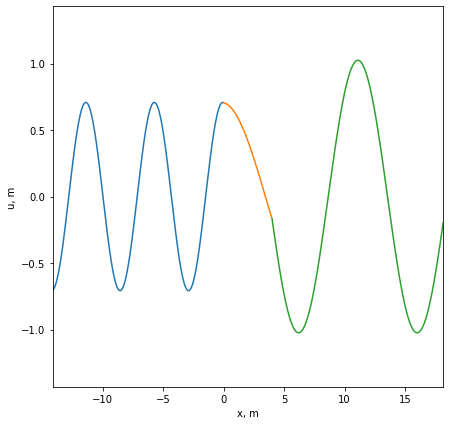

Saving figs/animation3.gif


MovieWriter stderr:
figs/animation3.gif: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '12', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'figs/animation3.gif']' returned non-zero exit status 1.

In [12]:
ms.animate_displacement('figs/animation3.gif')

### Display animation of displacement
![SegmentLocal](figs/animation3.gif "segment")

## TODO
- improve plot (edges)
- MS
  - test_boundary_conditions (in base class)
- superposition
- time dependent?